In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from scipy.optimize import minimize
from scipy.stats import norm, t

### Data Processing and Portfolio Performance

In [21]:
# Import data
def getData(stocks, start, end):
    stockData = yf.download(tickers=stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix
# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)
    return returns, std

assets = ['^GSPC', '^IXIC', '^DJI']
endDate = dt.datetime.today()
startDate = endDate - dt.timedelta(days=252*3)
returns, meanReturns, covMatrix = getData(assets, start=startDate, end=endDate)
returns = returns.dropna()
weights = np.array([0.3, 0.4, 0.3])
returns['portfolio'] = returns.dot(weights)
returns

[*********************100%***********************]  3 of 3 completed


,^DJI,^GSPC,^IXIC,portfolio
Date,,,,
2021-06-17 00:00:00-04:00,-0.006177,-0.000436,0.008666,0.000572
2021-06-18 00:00:00-04:00,-0.015769,-0.013124,-0.009248,-0.012755
2021-06-21 00:00:00-04:00,0.017630,0.014002,0.007919,0.013265
2021-06-22 00:00:00-04:00,0.002025,0.005124,0.007905,0.005029
2021-06-23 00:00:00-04:00,-0.002102,-0.001083,0.001295,-0.000675
...,...,...,...,...
2023-07-05 00:00:00-04:00,-0.003772,-0.001968,-0.001818,-0.002464
2023-07-06 00:00:00-04:00,-0.010685,-0.007923,-0.008165,-0.008824
2023-07-07 00:00:00-04:00,-0.005524,-0.002865,-0.001339,-0.003205


### Portfolio Returns and Volaility

In [31]:
TRADING_DAYS = 5
pVal = 100
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, TRADING_DAYS)
print(f"Portfolio Returns/Std over {TRADING_DAYS} days: {round(pRet,5)}/{round(pStd,5)}")

Portfolio Returns/Std over 5 days: 0.00058/0.02791


### Parametric VaR with Liquidity risk 

In [32]:
def para_var(tradeAmt, portfolioValue, portofolioReturns, portfolioStd, alpha=5):
    total_VaR = []
    for tradingAmt in tradeAmt:
        VaR = (norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns)*(portfolioValue-tradingAmt)
        total_VaR.append(VaR)
        portfolioValue -= tradingAmt
    return np.sum(total_VaR)
def trading_cost(tradeAmt, p1, p2, p3):
    spread_func = p1 + p2*np.exp(p3*tradeAmt)
    tc = (spread_func/2)*tradeAmt
    return np.sum(tc)
def func_to_minimize(tradeAmt, portfolioValue, portofolioReturns, portfolioStd, p1, p2, p3):
    return para_var(tradeAmt, portfolioValue, portofolioReturns, portfolioStd) + trading_cost(tradeAmt, p1, p2, p3)

### VaR calculations from unwinding a large position

In [33]:
""" Unwinding a Large Position equally over the duration of TRADING_DAYS"""
p1 = 0.08
p2 = 0.02
p3 = 0.05
init_guess = np.array(TRADING_DAYS*[pVal/TRADING_DAYS]) 
tradeAmt = np.array(init_guess)
func_to_minimize(tradeAmt, pVal, pRet, pStd, p1, p2, p3)

15.783314454312531

### Trading Cost: Spread Function

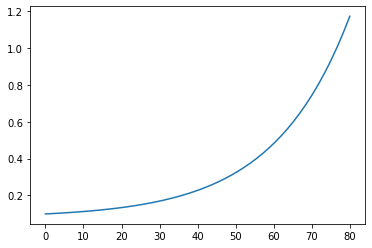

In [35]:
spread_func = p1 + p2*np.exp(p3*tradingAmt)
plt.plot(np.linspace(0, 80), spread_func)

### Minimizing VaR to find optimal amount to unload

In [39]:
tradeAmt = np.array(init_guess)
func_to_minimize(tradeAmt, pVal, pRet, pStd, p1, p2, p3)
args = (pVal, pRet, pStd, p1, p2, p3)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - pVal})
bounds = tuple((0,pVal) for i in range(TRADING_DAYS))
results = minimize(fun=func_to_minimize, x0=init_guess, method = 'SLSQP', 
         args=args, bounds=bounds, constraints=constraints)
print(f"Amount of unload over {TRADING_DAYS} days: {[round(x,2) for x in results['x']]}")

Amount of unload over 5 days: [35.32, 30.55, 23.63, 10.5, 0.0]
